<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data
    \-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression
*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

## Load the dataframe


Load the data


In [10]:
#data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')

data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [11]:
#X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')

X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [12]:
Y=data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [13]:
# students get this 
transform = preprocessing.StandardScaler()

In [14]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01,
        -1.57589457e+00, -9.73440458e-01, -1.05999788e-01,
        -1.05999788e-01, -6.54653671e-01, -1.05999788e-01,
        -5.51677284e-01,  3.44342023e+00, -1.85695338e-01,
        -3.33333333e-01, -1.05999788e-01, -2.42535625e-01,
        -4.29197538e-01,  7.97724035e-01, -5.68796459e-01,
        -4.10890702e-01, -4.10890702e-01, -1.50755672e-01,
        -7.97724035e-01, -1.50755672e-01, -3.92232270e-01,
         9.43398113e+00, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.50755672e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.50755672e-01, -1.05999788e-0

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=2)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (72, 83) (72,)
Test set: (18, 83) (18,)


we can see we only have 18 test samples.


In [17]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object using then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [18]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [20]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

LR = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,Y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

print("yhat: ", yhat)
print("yhat_prob: ",yhat_prob)

yhat:  [1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1]
yhat_prob:  [[0.31575125 0.68424875]
 [0.16763308 0.83236692]
 [0.23666893 0.76333107]
 [0.17174248 0.82825752]
 [0.25380985 0.74619015]
 [0.17798224 0.82201776]
 [0.1951042  0.8048958 ]
 [0.63389092 0.36610908]
 [0.18214528 0.81785472]
 [0.58445662 0.41554338]
 [0.59904046 0.40095954]
 [0.34220165 0.65779835]
 [0.31851887 0.68148113]
 [0.16522618 0.83477382]
 [0.24745211 0.75254789]
 [0.25429632 0.74570368]
 [0.34246043 0.65753957]
 [0.326117   0.673883  ]]


In [106]:
LR2 = LogisticRegression(C=0.01, penalty='l2', solver='lbfgs').fit(X_train,Y_train)
yhatLR = LR2.predict(X_test)
yhatLR_prob = LR2.predict_proba(X_test)
LR2.score(X_test, Y_test)


0.8333333333333334

In [21]:
# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(LR, parameters, cv=10)

# Fit it to the data
logreg_cv.fit(X, Y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score is 0.8222222222222222


We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [22]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8222222222222222


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [45]:
LR.score(X_test, Y_test)

0.8333333333333334

Lets look at the confusion matrix:


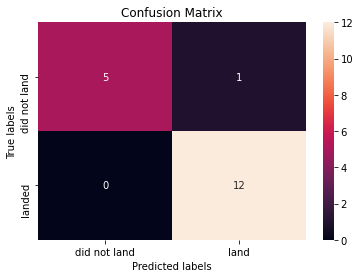

In [46]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [109]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm.fit(X_train, Y_train) 
yhat2 = svm.predict(X_test)
yhat2 [0:5]

array([0, 1, 1, 1, 1])

In [34]:
#clf = svm.SVC()
#clf.fit(X_train, Y_train) 
#yhat = clf.predict(X_test)
#yhat [0:5]

In [110]:
# Instantiate the GridSearchCV object: logreg_cv
svm_cv = GridSearchCV(svm, parameters, cv=10)

# Fit it to the data
svm_cv.fit(X, Y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Best score is 0.8222222222222223


In [49]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8222222222222223


In [111]:
svm2 = SVC(C = 1.0, gamma=0.03162277660168379, kernel='sigmoid')
svm2.fit(X_train, Y_train) 
yhatSVM = svm2.predict(X_test)
#yhatSVM [0:5]
svm2.score(X_test, Y_test)

0.8333333333333334

## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [113]:
svm2.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


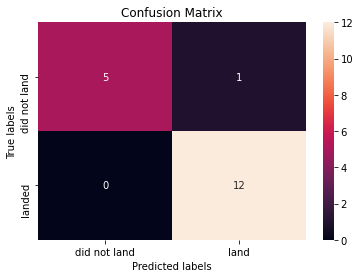

In [114]:
yhatconfusion=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhatconfusion)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [64]:
from sklearn import metrics
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=4,max_features='sqrt',min_samples_leaf=2,min_samples_split=2)
tree.fit(X_train,Y_train)
predicTree = tree.predict(X_test)
print("Decision Trees's Accuracy: ", metrics.accuracy_score(Y_test, predicTree))


Decision Trees's Accuracy:  0.8333333333333334


In [68]:
# Instantiate the GridSearchCV object: logreg_cv
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Fit it to the data
tree_cv.fit(X, Y)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(tree_cv.best_params_)) 
print("Best score is {}".format(tree_cv.best_score_))

Tuned Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Best score is 0.888888888888889


In [93]:
#tree2 = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=2,max_features='auto',min_samples_leaf=4,min_samples_split=10)
tree2 = DecisionTreeClassifier(criterion='gini',splitter='random',max_depth=4,max_features='auto',min_samples_leaf=2,min_samples_split=10)

tree2.fit(X_train,Y_train)
predicTree2 = tree2.predict(X_test)
print("Decision Trees's Accuracy: ", metrics.accuracy_score(Y_test, predicTree2))                     
                        
                        

Decision Trees's Accuracy:  0.8333333333333334


In [66]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8777777777777779


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [69]:
tree_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


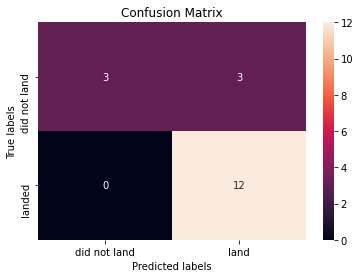

In [70]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [117]:
from sklearn import metrics
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

#KNN = KNeighborsClassifier()
k = 3
#KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
KNN = KNeighborsClassifier(n_neighbors = 5,algorithm='auto',p= 1).fit(X_train,Y_train)
yhatKNN = KNN.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, KNN.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, yhatKNN))

Train set Accuracy:  0.875
Test set Accuracy:  0.8333333333333334


In [85]:
# Instantiate the GridSearchCV object: logreg_cv
knn_cv = GridSearchCV(KNN, parameters, cv=10)

# Fit it to the data
knn_cv.fit(X, Y)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(knn_cv.best_params_)) 
print("Best score is {}".format(knn_cv.best_score_))


Tuned Parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
Best score is 0.8444444444444444


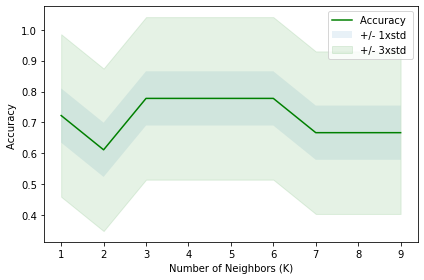

The best accuracy was 0.7777777777777778 with k= 3


In [86]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,Y_train)
    yhat2=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(Y_test, yhat2)

    
    std_acc[n-1]=np.std(yhat==Y_test)/np.sqrt(yhat.shape[0])

mean_acc


plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()


print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [87]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
accuracy : 0.8444444444444444


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [88]:
knn_cv.score(X_test, Y_test)

0.9444444444444444

We can plot the confusion matrix


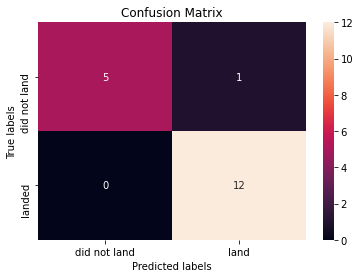

In [89]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


In [107]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
#use score() on new models based on the recommended best parameters for each
#logreg
print ('score: ', LR2.score(X_test, Y_test))
#jaccard
print ('Jaccard score for pos_label=COLLECTION: ', jaccard_score(Y_test, yhatLR, pos_label=0))
#f-1 score (find average of f-1 for both labels)
print('F1 score: ', f1_score(Y_test, yhatLR, average='weighted'))
#logloss
test_loan_proba = LR.predict_proba(X_test)
print('Log Loss: ', log_loss(Y_test, yhatLR,))


score:  0.8333333333333334
Jaccard score for pos_label=COLLECTION:  0.5
F1 score:  0.8148148148148149
Log Loss:  5.75659599872348


In [115]:
#SVM
#svm2.score(X_test, Y_test)
print ('score: ', svm2.score(X_test, Y_test))
#jaccard
print ('Jaccard score for pos_label=COLLECTION: ', jaccard_score(Y_test, yhatSVM, pos_label=0))
#f-1 score (find average of f-1 for both labels)
print('F1 score: ', f1_score(Y_test, yhatSVM, average='weighted'))

score:  0.8333333333333334
Jaccard score for pos_label=COLLECTION:  0.5
F1 score:  0.8148148148148149


In [116]:
#tree
#tree2.score(X_test, Y_test)

print ('score: ', tree2.score(X_test, Y_test))
#jaccard
print ('Jaccard score for pos_label=COLLECTION: ', jaccard_score(Y_test, predicTree2, pos_label=0))
#f-1 score (find average of f-1 for both labels)
print('F1 score: ', f1_score(Y_test, predicTree2, average='weighted'))

score:  0.8333333333333334
Jaccard score for pos_label=COLLECTION:  0.5
F1 score:  0.8148148148148149


In [118]:
#KNN
#KNN.score(X_test, Y_test)
print ('score: ', KNN.score(X_test, Y_test))
#jaccard
print ('Jaccard score for pos_label=COLLECTION: ', jaccard_score(Y_test, yhatKNN, pos_label=0))
#f-1 score (find average of f-1 for both labels)
print('F1 score: ', f1_score(Y_test, yhatKNN, average='weighted'))


score:  0.8333333333333334
Jaccard score for pos_label=COLLECTION:  0.5
F1 score:  0.8148148148148149


In [ ]:
#All the models seem to perform equally well

## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2020-09-20        | 1.0     | Joseph     | Modified Multiple Areas |


Copyright © 2020 IBM Corporation. All rights reserved.
